<a href="https://colab.research.google.com/github/yfpang7/dataScience_projects/blob/main/FFN_predictingHeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
import polars as pl
import pandas as pd
import numpy as np
import polars.selectors as cs
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
import sklearn.metrics as skm
import shap

In [303]:
# importing
url =  'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

raw_data = pl.read_csv(
    url,
    infer_schema_length=1000,
    has_header=False,
    new_columns=columns
    )

raw_data.head()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64
63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,"""0.0""","""6.0""",0
67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,"""3.0""","""3.0""",2
67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,"""2.0""","""7.0""",1
37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,"""0.0""","""3.0""",0
41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,"""0.0""","""3.0""",0


In [304]:
raw_data['DISEASE'].value_counts()

DISEASE,count
i64,u32
2,36
0,164
3,35
4,13
1,55


In [305]:
# previously used label 0, 1, 2, 3, 4 and got 50% accrucy
# reduce label to 0 and 1 to try improve performance
# one hot encoding: 0 = no chance; >0 = 1 (there's chance))
raw_data = (
    raw_data
    .with_columns(
        DISEASE=pl.when(pl.col('DISEASE') > 0)
        .then(1)
        .otherwise(0)
    )
    # .select('DISEASE').unique()
)


In [306]:
# find any null
raw_data.filter(pl.any_horizontal(pl.all().is_null()))

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i32


In [307]:
# find any weird values
raw_data.filter(pl.any_horizontal(pl.col(pl.String).str.contains(r"\?")))

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i32
53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,"""0.0""","""?""",0
52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,"""?""","""3.0""",0
43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,"""?""","""7.0""",1
52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,"""0.0""","""?""",1
58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,"""?""","""7.0""",0
38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,"""?""","""3.0""",0


In [308]:
'''
thalach = maximum heart rate achieved
chol = serum cholesteral
fasting blood sugar ( > 120 mg/dl)
trestbps = resting blood pressure (on admission to the hospital)
thalach = maximum heart rate achieved
exang = exercise induced angina
oldpeak =  ST depression induced by exercise relative to rest
ca = number of major vessels (0-3) colored by flourosopy
num = diagnosis of heart disease
'''

raw_data = (
    raw_data
    .with_columns(
        pl.col('age').cast(pl.Int8),
        pl.col('ca').replace('?', None).cast(pl.Float64),
        pl.col('thal').replace('?', None).cast(pl.Float64),
        pl.col('sex').cast(pl.Int8),
        pl.col('cp').cast(pl.Int8),
        pl.col('DISEASE').cast(pl.Int8),
        pl.col('fbs').cast(pl.Int8),
        pl.col('restecg').cast(pl.Int8),
        pl.col('exang').cast(pl.Int8),
        pl.col('trestbps').cast(pl.Float64),
        pl.col('chol').cast(pl.Float64),
        pl.col('thalach').cast(pl.Float64),
        pl.col('oldpeak').cast(pl.Float64),
        pl.col('slope').cast(pl.Int8),
    )
)

raw_data.head()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
i8,i8,i8,f64,f64,i8,i8,f64,i8,f64,i8,f64,f64,i8
63,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6.0,0
67,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3.0,1
67,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7.0,1
37,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0.0,3.0,0
41,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0.0,3.0,0


In [309]:
# find the unique for each column
[raw_data[col].unique() for col in raw_data.columns]

[shape: (41,)
 Series: 'age' [i8]
 [
 	29
 	34
 	35
 	37
 	38
 	…
 	70
 	71
 	74
 	76
 	77
 ],
 shape: (2,)
 Series: 'sex' [i8]
 [
 	0
 	1
 ],
 shape: (4,)
 Series: 'cp' [i8]
 [
 	1
 	2
 	3
 	4
 ],
 shape: (50,)
 Series: 'trestbps' [f64]
 [
 	94.0
 	100.0
 	101.0
 	102.0
 	104.0
 	…
 	174.0
 	178.0
 	180.0
 	192.0
 	200.0
 ],
 shape: (152,)
 Series: 'chol' [f64]
 [
 	126.0
 	131.0
 	141.0
 	149.0
 	157.0
 	…
 	394.0
 	407.0
 	409.0
 	417.0
 	564.0
 ],
 shape: (2,)
 Series: 'fbs' [i8]
 [
 	0
 	1
 ],
 shape: (3,)
 Series: 'restecg' [i8]
 [
 	0
 	1
 	2
 ],
 shape: (91,)
 Series: 'thalach' [f64]
 [
 	71.0
 	88.0
 	90.0
 	95.0
 	96.0
 	…
 	190.0
 	192.0
 	194.0
 	195.0
 	202.0
 ],
 shape: (2,)
 Series: 'exang' [i8]
 [
 	0
 	1
 ],
 shape: (40,)
 Series: 'oldpeak' [f64]
 [
 	0.0
 	0.1
 	0.2
 	0.3
 	0.4
 	…
 	4.0
 	4.2
 	4.4
 	5.6
 	6.2
 ],
 shape: (3,)
 Series: 'slope' [i8]
 [
 	1
 	2
 	3
 ],
 shape: (5,)
 Series: 'ca' [f64]
 [
 	null
 	0.0
 	1.0
 	2.0
 	3.0
 ],
 shape: (4,)
 Series: 'thal' [

In [310]:
raw_data.shape

(303, 14)

In [311]:
# find nulls
raw_data.filter(pl.any_horizontal(pl.all().is_null()))

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
i8,i8,i8,f64,f64,i8,i8,f64,i8,f64,i8,f64,f64,i8
53,0,3,128.0,216.0,0,2,115.0,0,0.0,1,0.0,null,0
52,1,3,138.0,223.0,0,0,169.0,0,0.0,1,null,3.0,0
43,1,4,132.0,247.0,1,2,143.0,1,0.1,2,null,7.0,1
52,1,4,128.0,204.0,1,0,156.0,1,1.0,2,0.0,null,1
58,1,2,125.0,220.0,0,0,144.0,0,0.4,2,null,7.0,0
38,1,3,138.0,175.0,0,0,173.0,0,0.0,1,null,3.0,0


In [312]:
# filling null with the average of the columns
raw_data = (
    raw_data
    .with_columns([
        pl.col('ca').fill_null(pl.col('ca').mean()),
        pl.col('thal').fill_null(pl.col('thal').mean()),
    ])
)

In [313]:
raw_data['DISEASE'].value_counts()

DISEASE,count
i8,u32
0,164
1,139


In [314]:
# select the features and the label
features = raw_data.select(cs.exclude('DISEASE'))
label = raw_data['DISEASE']

In [315]:
# split the data before scaling to avoid data leaks
X_train, X_test, y_train, y_test = train_test_split(
    features.to_numpy(),
    label.to_numpy(),
    test_size=0.2,
    random_state=42,
    stratify=label
    )

In [316]:
# scale the features since different metrics
# minmax because neural nets activation function works best in those range
# remember - if there are some one-hot encoding then becareful of z-score normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [317]:
# check the scaled features = make sure those one-hot encoding like sex not affected
pl.DataFrame(X_train_scaled, schema=[c for c in columns if c != 'DISEASE']).head(2)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.395833,1.0,1.0,0.283019,0.3379,0.0,1.0,0.725191,0.0,0.080645,0.5,0.0,1.0
0.541667,1.0,0.333333,0.339623,0.310502,0.0,0.0,0.641221,0.0,0.0,0.0,0.0,0.0


In [318]:
# convert to tensors and create data loaders
# cross entropy expects long or torch.int64
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [319]:
# convert to pytorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [320]:
# translate to dataloader
batchSize = 16
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [321]:
# create the model and components
class ANNmodel(nn.Module):
  def __init__(self, input_size, nUnits, nLayers):
    super().__init__()
    # create a dictionary to store the layers
    self.layers = nn.ModuleDict()
    # create input layer
    self.layers['input'] = nn.Linear(input_size, nUnits)
    # hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}']  = nn.Linear(nUnits, nUnits)
    # output layer
    self.layers['output'] = nn.Linear(nUnits, 2)
  # forward pass
  def forward(self, x):
    x = F.relu(self.layers['input'](x))
    for i in range(len(self.layers) - 2):
      x = F.relu(self.layers[f'hidden{i}'](x))
    # output layer
    x = self.layers['output'](x)
    return x

In [322]:
# create the model components
def createANNnet(input_size, nUnits, nLayers, learningRate=.001):
  model = ANNmodel(input_size, nUnits, nLayers)
  lossfunc = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.95)

  return model, lossfunc, optimizer, scheduler

In [323]:
def trainModel(train_loader, test_loader, input_size, nUnits, nLayers, numepochs=500, toggleDynamic=False):
    training_progress = pl.DataFrame(
        schema=[
            ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64)
        ]
    )
    iteration = 0
    # create the ann model
    model, lossfunc, optimizer, scheduler = createANNnet(input_size, nUnits, nLayers)
    # early stopping parameters
    patience = 20
    best_loss = float('inf')
    no_improve_count = 0
    best_model = None

    # training loop
    for epoch in range(numepochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # iterate through training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            # backprop
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # evaluate training accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # sum of the loss and accuracy
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()
            num_batches += 1
            iteration += 1

        # update the learning rate after all batches (once per epoch)
        if toggleDynamic:
            scheduler.step()
            current_lrs = scheduler.get_last_lr()[0]
        else:
            current_lrs = optimizer.param_groups[0]['lr']

        # evaluate the test set
        model.eval()
        test_loss_total = 0
        test_acc_total = 0
        test_batches = 0

        with torch.no_grad():
            for X_testTL, y_testTL in test_loader:
                yhat_test = model(X_testTL)
                test_loss = lossfunc(yhat_test, y_testTL)

                # Get test accuracy
                test_matches = (torch.argmax(yhat_test, axis=1) == y_testTL).float()
                test_acc = 100 * torch.mean(test_matches)

                # sum of the loss and accuracy
                test_loss_total += test_loss.item()
                test_acc_total += test_acc.item()
                test_batches += 1

        # average test metrics
        avg_test_loss = test_loss_total / test_batches
        avg_test_acc = test_acc_total / test_batches

        # log a single row per epoch and append the new row to the training data
        new_row = pl.DataFrame([{
            'iteration': iteration,
            'epoch': epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc': epoch_train_acc / num_batches,
            'test_loss': avg_test_loss,
            'test_acc': avg_test_acc,
            'learning_rate': current_lrs
        }])
        training_progress = training_progress.vstack(new_row)

        # Early stopping condition
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            no_improve_count = 0 # reset counter to zero
            best_model = copy.deepcopy(model)
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f'Early stopping at epoch {epoch + 1} - No improvement for {patience} epochs')
                break

        # print out performance after every 20 epochs
        if epoch % 20 == 0 or epoch == numepochs - 1:
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={avg_test_loss:.4f}, "
                f"Accuracy={avg_test_acc:.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )

    # return both training model progress and best model
    return training_progress, best_model if best_model is not None else model

In [324]:
# train the model
training_progress, trained_model = trainModel(
    train_loader=train_loader,
    test_loader=test_loader,
    input_size=13,
    nUnits=32,
    nLayers=2,
    numepochs=500,
    toggleDynamic=False
    )


Epoch 1/500 - Training: Loss=0.6723, Accuracy=63.75% | Testing: Loss=0.6558, Accuracy=75.41% | Learning Rate: 0.001000
Epoch 21/500 - Training: Loss=0.3361, Accuracy=85.83% | Testing: Loss=0.3583, Accuracy=83.61% | Learning Rate: 0.001000
Epoch 41/500 - Training: Loss=0.2751, Accuracy=90.00% | Testing: Loss=0.3673, Accuracy=85.25% | Learning Rate: 0.001000
Early stopping at epoch 50 - No improvement for 20 epochs


In [325]:
training_progress.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate
i64,i64,f64,f64,f64,f64,f64
15,0,0.672341,63.75,0.655826,75.409836,0.001
30,1,0.630416,79.583333,0.609589,77.049179,0.001
45,2,0.574053,81.25,0.540119,77.049179,0.001
60,3,0.50031,82.5,0.470452,78.688522,0.001
75,4,0.441554,82.5,0.423983,75.409836,0.001


In [326]:
# run the model a 10 times and get the average
# there were some overfitting hence I am reducing the model complexity by reducing the layers and nodes

all_progress = []

for i in range(10):
  training_progress, trained_model = trainModel(
    train_loader=train_loader,
    test_loader=test_loader,
    input_size=13,
    nUnits=32,
    nLayers=2,
    numepochs=500,
    toggleDynamic=False
    )

  training_progress = training_progress.with_columns(experiment_num=pl.lit(i))

  all_progress.append(training_progress)


data = pl.concat(all_progress)

Epoch 1/500 - Training: Loss=0.6909, Accuracy=56.25% | Testing: Loss=0.6850, Accuracy=73.77% | Learning Rate: 0.001000
Epoch 21/500 - Training: Loss=0.3441, Accuracy=85.42% | Testing: Loss=0.3514, Accuracy=85.25% | Learning Rate: 0.001000
Early stopping at epoch 41 - No improvement for 20 epochs
Epoch 1/500 - Training: Loss=0.6895, Accuracy=54.17% | Testing: Loss=0.6828, Accuracy=54.10% | Learning Rate: 0.001000
Epoch 21/500 - Training: Loss=0.3236, Accuracy=86.67% | Testing: Loss=0.3313, Accuracy=83.61% | Learning Rate: 0.001000
Epoch 41/500 - Training: Loss=0.3010, Accuracy=88.33% | Testing: Loss=0.3002, Accuracy=86.89% | Learning Rate: 0.001000
Early stopping at epoch 61 - No improvement for 20 epochs
Epoch 1/500 - Training: Loss=0.7113, Accuracy=45.83% | Testing: Loss=0.7014, Accuracy=45.90% | Learning Rate: 0.001000
Epoch 21/500 - Training: Loss=0.3175, Accuracy=87.50% | Testing: Loss=0.3572, Accuracy=81.97% | Learning Rate: 0.001000
Early stopping at epoch 35 - No improvement for

In [327]:
# inspect the performance data
data.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,experiment_num
i64,i64,f64,f64,f64,f64,f64,i32
15,0,0.690925,56.25,0.68497,73.770493,0.001,0
30,1,0.676505,73.75,0.669357,80.327866,0.001,0
45,2,0.655298,76.666667,0.641405,85.245903,0.001,0
60,3,0.61659,79.583333,0.591977,81.967209,0.001,0
75,4,0.553692,83.333333,0.519568,83.60656,0.001,0


In [328]:
fig = px.scatter(
    data_frame=data,
    x='epoch',
    y=['train_acc', 'test_acc'],
    facet_col='experiment_num',
    facet_col_wrap=4
)

fig.update_traces(marker=dict(size=4, line=dict(width=0.5, color='darkslategray')))
fig.update_layout(template='ggplot2', width=900)

In [329]:
fig = px.scatter(
    data_frame=data,
    x='epoch',
    y=['train_loss', 'test_loss'],
    facet_col='experiment_num',
    facet_col_wrap=4
)

fig.update_traces(marker=dict(size=4, line=dict(width=0.5, color='darkslategray')))
fig.update_layout(template='ggplot2', width=900)

### Interpretation (Post simplifying the model)
* Noticed test oss increases after certain number of epochs which suggest overfitting in neural network
* suggest the model is too complex and start fitting noise or specific patterns in training data
* suggestions to fix:
  * early stopping
  * regulazrization such as dropout layers
  * data augmentation to diversity the data
  * **Simplyfying the model** - reudce the layers and parameters


In [330]:
with torch.no_grad():
    trained_model.eval()
    # Get raw model outputs on training data
    train_yhat = trained_model(train_loader.dataset.tensors[0])  # Raw logits
    train_predictions = torch.argmax(train_yhat, axis=1)          # Convert to class predictions

    # Get raw model outputs on test data
    test_yhat = trained_model(test_loader.dataset.tensors[0])     # Raw logits
    test_predictions = torch.argmax(test_yhat, axis=1)            # Convert to class predictions

In [331]:
train_predictions

tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0])

In [332]:
# computing precision et al. in multiclass data
## note: average=None - used when need to diagnose which specific classes are problematic
## weighted: when we care more about overall peformance and want frequent classes to matter more
## marcro: when we wat to ensure all classes are treated equally, especially useful when you care about minority class performance
skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average=None)

array([0.84615385, 0.8989899 ])

In [333]:
skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)

array([0.93103448, 0.8125    ])

In [334]:
# calculate metrics (same as before)
train_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]

train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions, average='weighted')

train_metrics

[0.8677685950413223,
 0.8703885646034406,
 0.8677685950413223,
 0.8668861331104198]

In [335]:
# calculate metrics (same as before)
test_metrics = [0, 0, 0, 0]
test_metrics = [0, 0, 0, 0]

test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions, average='weighted')

test_metrics

[0.8688524590163934,
 0.8766252119841718,
 0.8688524590163934,
 0.8689934778776661]

In [336]:
metrics_df = pl.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'] * 2,
    'Score': train_metrics + test_metrics,
    'Dataset': ['Train'] * 4 + ['Test'] * 4
})

print(metrics_df)

shape: (8, 3)
┌───────────┬──────────┬─────────┐
│ Metric    ┆ Score    ┆ Dataset │
│ ---       ┆ ---      ┆ ---     │
│ str       ┆ f64      ┆ str     │
╞═══════════╪══════════╪═════════╡
│ Accuracy  ┆ 0.867769 ┆ Train   │
│ Precision ┆ 0.870389 ┆ Train   │
│ Recall    ┆ 0.867769 ┆ Train   │
│ F1-score  ┆ 0.866886 ┆ Train   │
│ Accuracy  ┆ 0.868852 ┆ Test    │
│ Precision ┆ 0.876625 ┆ Test    │
│ Recall    ┆ 0.868852 ┆ Test    │
│ F1-score  ┆ 0.868993 ┆ Test    │
└───────────┴──────────┴─────────┘


In [337]:
fig = px.bar(metrics_df, x='Metric', y='Score', color='Dataset',
             title='Performance Metrics', barmode='group',
             range_y=[0.6, 1.0])

fig.update_layout(template='ggplot2', width=600)
fig.show()

In [338]:
# class-specific precision and recall for test data
# use none show all class
precision_classSpecific = skm.precision_score(test_loader.dataset.tensors[1], test_predictions, average=None)
recall_classSpecific = skm.recall_score(test_loader.dataset.tensors[1], test_predictions, average=None)


classSpecificPerformance = (
    pl.DataFrame({
    'precision' : precision_classSpecific,
    'recall' : recall_classSpecific
    })
    .with_row_index(name='Number')
    .unpivot(index='Number', variable_name='PerformanceMetrics')
)

classSpecificPerformance

Number,PerformanceMetrics,value
u32,str,f64
0,"""precision""",0.931034
1,"""precision""",0.8125
0,"""recall""",0.818182
1,"""recall""",0.928571


In [339]:
# confusion matrix to see when it is FP or FN what they tend to misclassified into?
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions, normalize='true')
testConf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions, normalize='true')

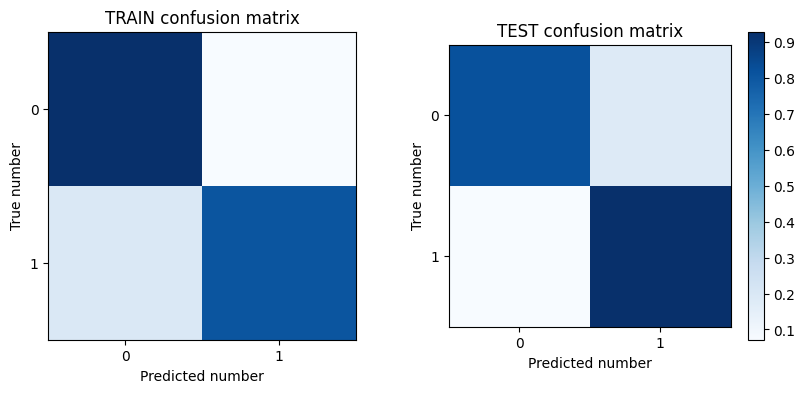

In [340]:
# Training confusion matrix
fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',)
ax[0].set_xticks(range(2))
ax[0].set_yticks(range(2))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',)
ax[1].set_xticks(range(2))
ax[1].set_yticks(range(2))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

In [341]:
# Convert test data to pandas for easier SHAP handling
feature_names = [col for col in columns if col != 'DISEASE']
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

In [342]:
# Create a wrapper function for SHAP that works with PyTorch model
def model_predict(X):
    """
    Wrapper function to make predictions with trained PyTorch model
    Returns probabilities for both classes
    """
    # Convert to tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Get predictions
    with torch.no_grad():
        trained_model.eval()
        outputs = trained_model(X_tensor)
        # Convert logits to probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    return probabilities.numpy()

In [343]:
# Test the wrapper function
print("Testing model wrapper...")
test_pred = model_predict(X_test_scaled[:5])
print(f"Prediction shape: {test_pred.shape}")
print(f"Sample predictions:\n{test_pred}")

Testing model wrapper...
Prediction shape: (5, 2)
Sample predictions:
[[0.8724992  0.12750076]
 [0.39985728 0.6001427 ]
 [0.9628576  0.03714237]
 [0.96432775 0.03567224]
 [0.56270915 0.43729085]]


In [344]:
# Initialize SHAP explainer
# Using a smaller background dataset for efficiency (100 samples)
background_size = min(100, X_train_scaled.shape[0])
background_indices = np.random.choice(X_train_scaled.shape[0], background_size, replace=False)
background_data = X_train_scaled[background_indices]

print(f"\nUsing {background_size} samples for SHAP background...")
explainer = shap.Explainer(model_predict, background_data)


Using 100 samples for SHAP background...


In [345]:
# Calculate SHAP values for test set (or subset for efficiency)
# Using first 50 test samples for demonstration
n_explain = min(50, X_test_scaled.shape[0])
shap_values = explainer(X_test_scaled[:n_explain])

In [346]:
len(shap_values[1])

13

/tmp/ipython-input-1987423303.py:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



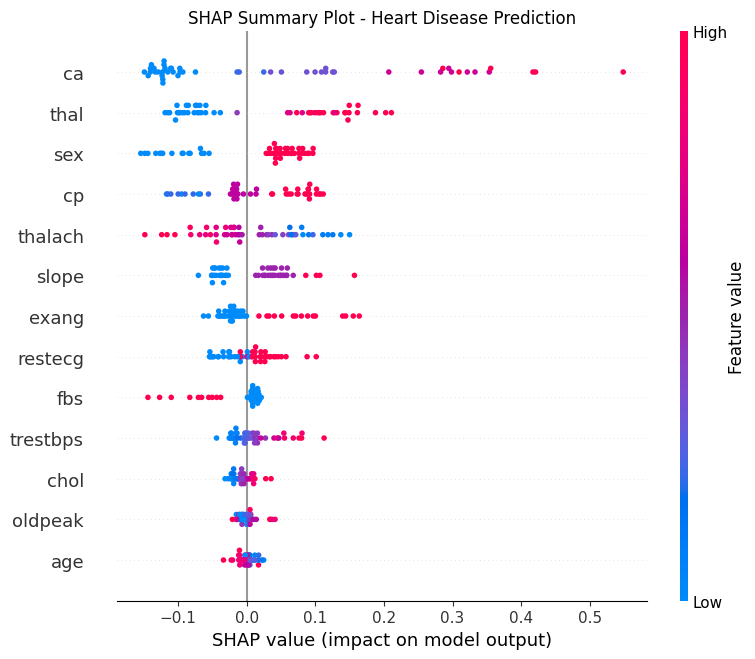

In [347]:
# shap visualization
shap.summary_plot(shap_values[:, :, 1], X_test_df.iloc[:n_explain],
                  feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Heart Disease Prediction")
plt.tight_layout()
plt.show()

### Important Features:
1) ca (major vessels) - Strongest Predictior
2) tha (thalassemia) - Second most important
3) exang (exercise-induced angina) - High Impact
4) Gender plays a significant role
5) cp (chest pain) - importatn diagnostic feature

### How Feature affect disease
Higher thalach (max heart rate ) - lower risk
female -  lower risk
lower ca value - lower risk


/tmp/ipython-input-4034952383.py:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



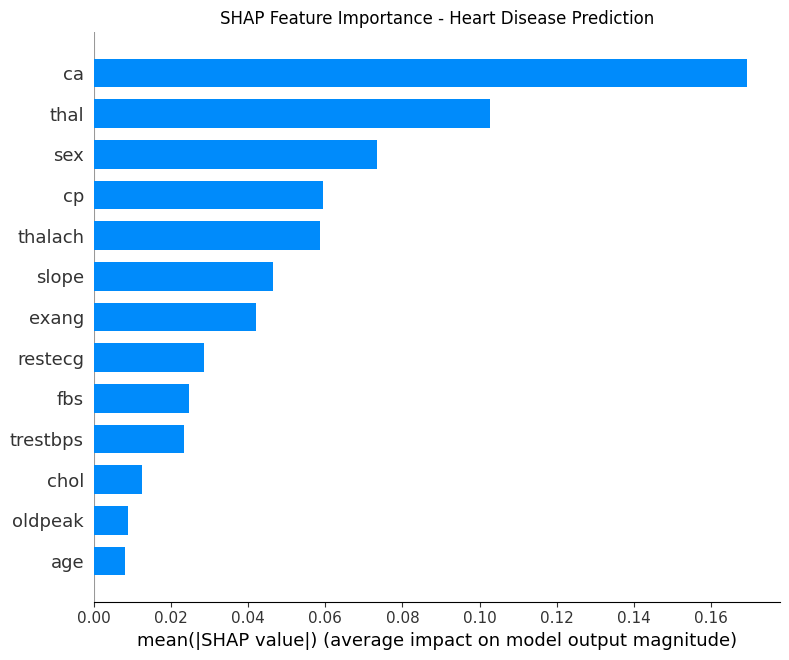

In [348]:
# average feature importance
shap.summary_plot(shap_values[:, :, 1], X_test_df.iloc[:n_explain],
                  plot_type="bar", feature_names=feature_names, show=False)
plt.title("SHAP Feature Importance - Heart Disease Prediction")
plt.tight_layout()
plt.show()


Waterfall plot for test sample 1:
Actual label: 0
Predicted probabilities: [0.8724992  0.12750074]


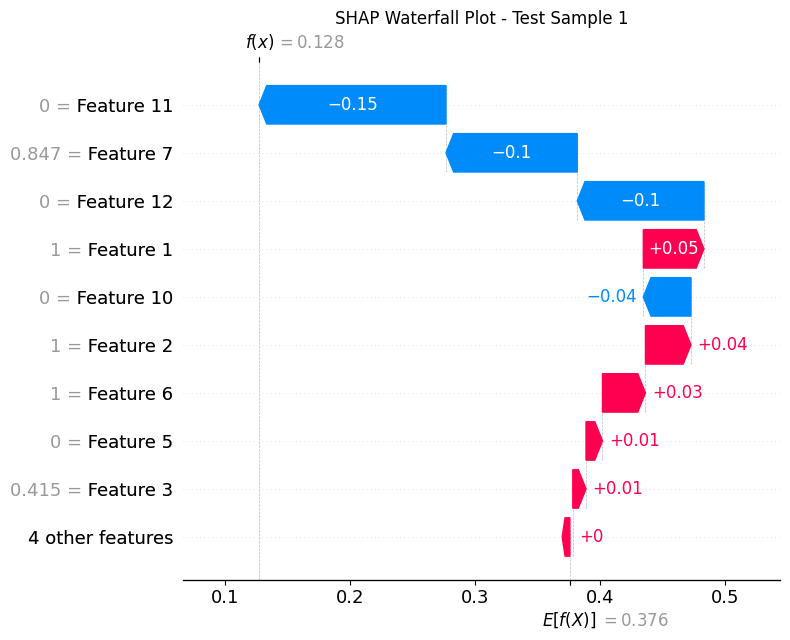


Waterfall plot for test sample 2:
Actual label: 0
Predicted probabilities: [0.39985734 0.60014266]


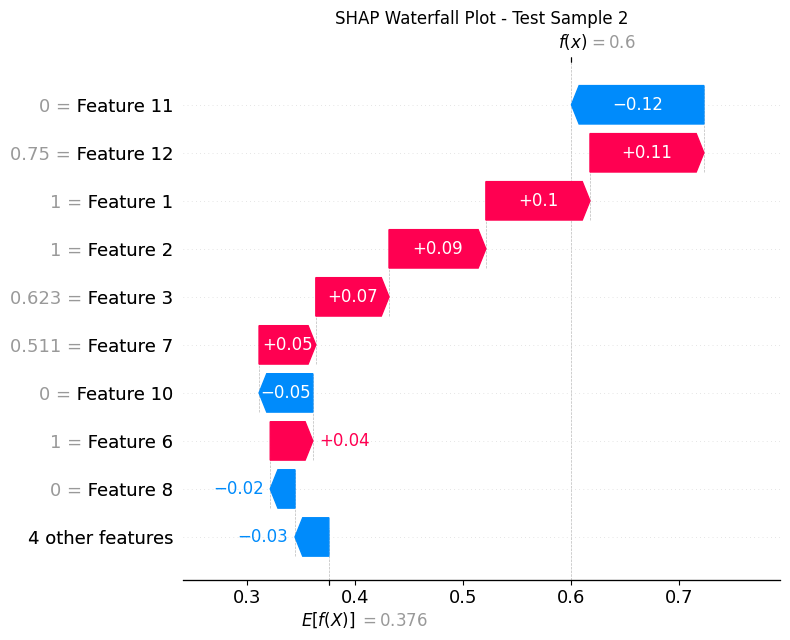


Waterfall plot for test sample 3:
Actual label: 0
Predicted probabilities: [0.9628576  0.03714237]


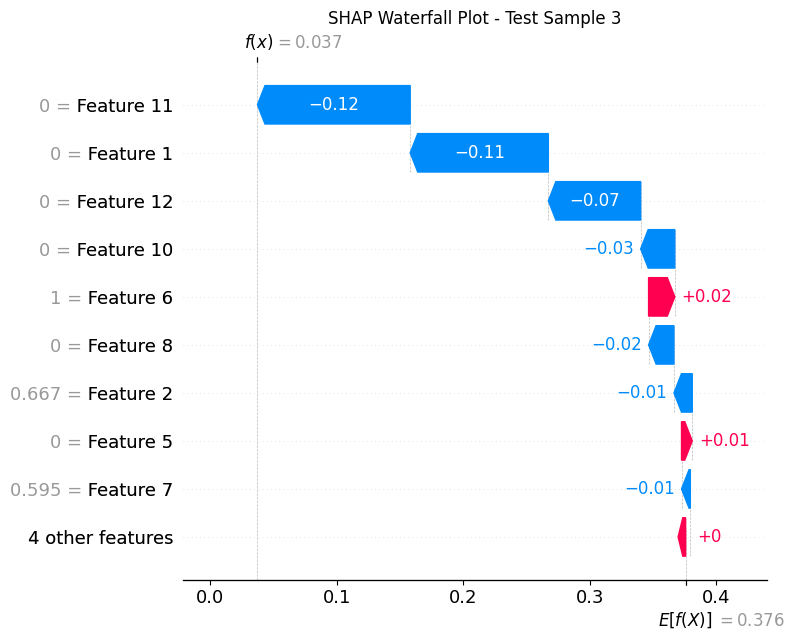

In [349]:
# Show explanations for first 3 test samples
for i in range(min(3, n_explain)):
    print(f"\nWaterfall plot for test sample {i+1}:")
    print(f"Actual label: {y_test[i]}")
    print(f"Predicted probabilities: {model_predict(X_test_scaled[i:i+1])[0]}")

    shap.waterfall_plot(shap_values[i, :, 1], show=False)
    plt.title(f"SHAP Waterfall Plot - Test Sample {i+1}")
    plt.tight_layout()
    plt.show()

In [350]:
# Feature importance ranking
print("\n=== Feature Importance Ranking ===")
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap_values
}).sort_values('importance', ascending=False)

print("Top features by SHAP importance:")
print(feature_importance)


=== Feature Importance Ranking ===
Top features by SHAP importance:
     feature  importance
11        ca    0.169350
12      thal    0.102738
1        sex    0.073431
2         cp    0.059284
7    thalach    0.058704
10     slope    0.046455
8      exang    0.042050
6    restecg    0.028499
5        fbs    0.024738
3   trestbps    0.023412
4       chol    0.012548
9    oldpeak    0.008872
0        age    0.008151


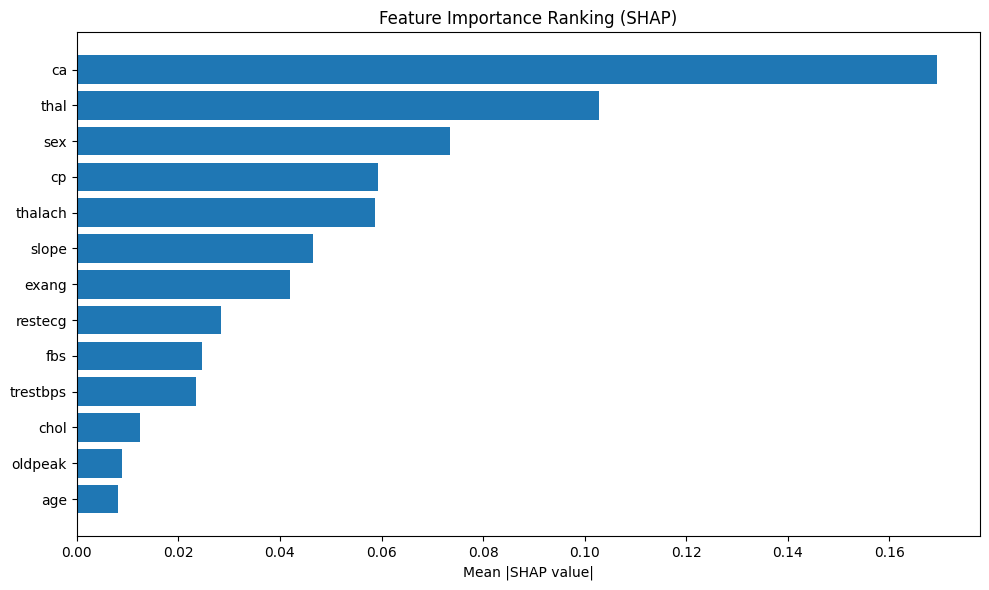

In [351]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Mean |SHAP value|')
plt.title('Feature Importance Ranking (SHAP)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [352]:
shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=feature_names)
print("\nFeature contribution statistics:")
print(shap_df.describe())


Feature contribution statistics:
             age        sex         cp   trestbps       chol        fbs  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.000268   0.006647   0.013169   0.010395  -0.006878  -0.006846   
std     0.011116   0.080746   0.069240   0.032606   0.013533   0.039861   
min    -0.034061  -0.154679  -0.117145  -0.044160  -0.031738  -0.144234   
25%    -0.004898  -0.067216  -0.020451  -0.014251  -0.018583   0.005617   
50%     0.000627   0.042141   0.000150   0.002744  -0.007956   0.008726   
75%     0.004505   0.065347   0.082327   0.015523   0.000874   0.013288   
max     0.024580   0.096697   0.111400   0.112663   0.035351   0.021034   

         restecg    thalach      exang    oldpeak      slope         ca  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.001831   0.006775   0.009052   0.000388   0.011480   0.053475   
std     0.035800   0.071215   0.057690   0.013058   0.051556   0.

In [353]:
shap_df = pd.DataFrame(shap_values.values[:, :, 1], columns=feature_names)
print("\nFeature contribution statistics:")
print(shap_df.describe())

# Correlation between SHAP values and features
print("\nCorrelation between features and their SHAP values:")
correlations = []
for i, feature in enumerate(feature_names):
    corr = np.corrcoef(X_test_scaled[:n_explain, i], shap_values.values[:, i, 1])[0, 1]
    correlations.append(corr)

correlation_df = pd.DataFrame({
    'feature': feature_names,
    'shap_feature_correlation': correlations
}).sort_values('shap_feature_correlation', key=abs, ascending=False)

print(correlation_df)


Feature contribution statistics:
             age        sex         cp   trestbps       chol        fbs  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.000268   0.006647   0.013169   0.010395  -0.006878  -0.006846   
std     0.011116   0.080746   0.069240   0.032606   0.013533   0.039861   
min    -0.034061  -0.154679  -0.117145  -0.044160  -0.031738  -0.144234   
25%    -0.004898  -0.067216  -0.020451  -0.014251  -0.018583   0.005617   
50%     0.000627   0.042141   0.000150   0.002744  -0.007956   0.008726   
75%     0.004505   0.065347   0.082327   0.015523   0.000874   0.013288   
max     0.024580   0.096697   0.111400   0.112663   0.035351   0.021034   

         restecg    thalach      exang    oldpeak      slope         ca  \
count  50.000000  50.000000  50.000000  50.000000  50.000000  50.000000   
mean    0.001831   0.006775   0.009052   0.000388   0.011480   0.053475   
std     0.035800   0.071215   0.057690   0.013058   0.051556   0.